In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import FeatureUnion
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.cluster import KMeans
from sklearn.metrics import make_scorer
import scipy.sparse as sp
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.preprocessing import PowerTransformer,QuantileTransformer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD


## Подключение kaggle

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"uservi","key":"dff434a25f67c658e5e5ec6e8ffb01ee"}'}

In [ ]:
! mkdir ~/.kaggle


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                          title                                           size  lastUpdated          downloadCount  
-----------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  
alexgude/california-traffic-collision-data-from-switrs       California Traffic Collision Data from SWITRS    1GB  2020-11-22 16:51:55           1208  
babyoda/women-entrepreneurship-and-labor-force               Women Entrepreneurship and Labor Force           1KB  2020-11-21 08:38:51           3028  
szymonjanowski/internet-articles-data-with-users-engagement  Internet news data with readers engagement       3MB  2020-11-21 17:09:57           1448  
sakshigoyal7/credit-card-customers                           Credit Card customers                          379KB  2020-11-19 07:38:44           5815  
imoore/2020-us-general-election-turnout-rates                2020 US General Election Tu

In [ ]:
!kaggle competitions download -c made-hw-3

 97% 58.0M/59.7M [00:00<00:00, 70.3MB/s]
100% 59.7M/59.7M [00:00<00:00, 135MB/s] 
 24% 9.00M/36.7M [00:00<00:01, 18.2MB/s]
100% 36.7M/36.7M [00:00<00:00, 62.6MB/s]
 96% 135M/140M [00:01<00:00, 142MB/s]
100% 140M/140M [00:01<00:00, 137MB/s]
  0% 0.00/228k [00:00<?, ?B/s]
100% 228k/228k [00:00<00:00, 234MB/s]
 26% 5.00M/19.4M [00:00<00:00, 46.5MB/s]
100% 19.4M/19.4M [00:00<00:00, 95.2MB/s]


In [ ]:
!pwd
!ls

/content
calendar.csv.zip  kaggle.json	   sample_data		  test.csv.zip
drive		  reviews.csv.zip  sample_submission.csv  train.csv.zip


In [ ]:
! unzip reviews.csv.zip -d train 

Archive:  reviews.csv.zip
  inflating: train/reviews.csv       


In [ ]:
! unzip train.csv.zip -d train

Archive:  train.csv.zip
  inflating: train/train.csv         


In [ ]:
! unzip test.csv.zip -d train


Archive:  test.csv.zip
  inflating: train/test.csv          


In [ ]:
! unzip -u calendar.csv.zip -d train  

Archive:  calendar.csv.zip
  inflating: train/calendar.csv      


## Загрузка данных


In [ ]:
# train = pd.read_csv("/content/train/train.csv")
train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/hw03-train.csv")
# reviews = pd.read_csv("/content/train/reviews.csv")
# reviews = pd.read_csv("/content/drive/My Drive/Colab Notebooks/HW03reviews.csv")
# calendar = pd.read_csv("/content/train/calendar.csv")
# test = pd.read_csv("/content/train/test.csv")
test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/hw03-test.csv")
# sample_submission = pd.read_csv("/content/sample_submission.csv")

In [ ]:
train = train.drop('Unnamed: 45', axis=1)

In [ ]:
list(set(train.columns.values) - set(test.columns.values))

['price']

In [ ]:
list(set(test.columns.values) - set(train.columns.values))

['Unnamed: 44']

## calendar analytics

In [ ]:
calendar.loc[calendar['available'] == 't', 'available_num'] = 1
calendar['available_num'] = calendar['available_num'].fillna(0)

In [ ]:
calendar['date'] = pd.to_datetime(calendar.date, format='%Y-%m-%d')

# Monday=0, Sunday=6.
calendar['dayofweek'] = calendar['date'].dt.dayofweek
calendar['is_weekend'] = calendar.dayofweek.isin([5,6])*1
calendar['is_weekend'].fillna(0, inplace = True)
calendar = calendar.astype({'is_weekend': str})



In [ ]:
# calendar['week'] = calendar['date'].dt.isocalendar()['week']

In [ ]:
# calendar['year'] = calendar['date'].dt.isocalendar()['year']

In [ ]:
calendar['lagged'] = calendar.sort_values(['listing_id', 'year', 'week'])\
.groupby(['listing_id', 'year', 'week'])['available_num'].shift(1)

In [ ]:
calendar

,listing_id,date,available,available_num,dayofweek,is_weekend,week,year,lagged
0,9554,2019-08-18,t,1.0,6,1,33,2019,NaN
1,97446,2019-11-04,f,0.0,0,0,45,2019,NaN
2,97446,2019-11-03,f,0.0,6,1,44,2019,NaN
3,97446,2019-11-02,f,0.0,5,1,44,2019,0.0
4,97446,2019-11-01,f,0.0,4,0,44,2019,0.0
...,...,...,...,...,...,...,...,...,...
27307470,27182471,2018-11-09,f,0.0,4,0,45,2018,0.0
27307471,27182471,2018-11-08,f,0.0,3,0,45,2018,0.0
27307472,27182471,2018-11-07,f,0.0,2,0,45,2018,0.0
27307473,27182471,2018-11-06,f,0.0,1,0,45,2018,0.0


In [ ]:
calendar['year'] = calendar['date'].dt.dayofweek

,listing_id,date,available,available_num,dayofweek,is_weekend
0,9554,2019-08-18,t,1.0,6,1
1,97446,2019-11-04,f,0.0,0,0
2,97446,2019-11-03,f,0.0,6,1
3,97446,2019-11-02,f,0.0,5,1
4,97446,2019-11-01,f,0.0,4,0


In [ ]:
calendar_analytics = calendar.pivot_table(values = 'available_num', 
                                          index = 'listing_id', 
                                          columns = 'is_weekend', 
                                          aggfunc='sum', 
                                          fill_value = 0).reset_index()

In [ ]:
calendar_analytics.set_index('listing_id')

is_weekend,0,1
listing_id,,
9554,235,94
11076,0,0
13913,261,104
17402,258,103
24328,259,104
...,...,...
29797787,139,61
29797809,126,49
29797854,34,0


In [ ]:
calendar_analytics['increase_week'] = calendar_analytics['1'] / calendar_analytics['0']

In [ ]:
calendar_analytics[calendar_analytics['increase_week'] == np.inf] = 0

In [ ]:
calendar_analytics.increase_week = calendar_analytics.increase_week.fillna(0)

In [ ]:
calendar_analytics[calendar_analytics['increase_week'] > 0].describe()

is_weekend,listing_id,0,1,increase_week
count,5.010600e+04,50106.000000,50106.000000,50106.000000
mean,1.857603e+07,132.132240,52.363410,0.410622
std,8.690784e+06,91.548434,36.618033,0.158914
min,9.554000e+03,1.000000,1.000000,0.008197
25%,1.283052e+07,46.000000,18.000000,0.382979
50%,2.049949e+07,117.000000,46.000000,0.398104
75%,2.609809e+07,230.000000,91.000000,0.404858
max,2.979850e+07,261.000000,105.000000,7.000000


In [ ]:
q1 = calendar_analytics[calendar_analytics['increase_week'] > 0].increase_week.quantile(0.05)
q2 = calendar_analytics[calendar_analytics['increase_week'] > 0].increase_week.quantile(0.95)

In [ ]:
calendar_analytics.loc[calendar_analytics['increase_week'] <= q1, 'increase_week_cat'] = 'low'
calendar_analytics.loc[calendar_analytics['increase_week'] > q2, 'increase_week_cat'] = 'high'
calendar_analytics.loc[(calendar_analytics['increase_week'] > q1) & (calendar_analytics['increase_week'] <= q2), 'increase_week_cat'] = 'mid'
calendar_analytics['increase_week_cat'].fillna('none', inplace = True)

In [ ]:
train1 = train.merge(calendar_analytics[['listing_id', 'increase_week_cat', 'increase_week']], 
                    how = 'left', left_on = 'id', right_on = 'listing_id').drop(['listing_id'],axis=1)
test1 = test.merge(calendar_analytics[['listing_id', 'increase_week_cat', 'increase_week']], 
                  how = 'left', left_on = 'id', right_on = 'listing_id').drop(['listing_id'],axis=1)

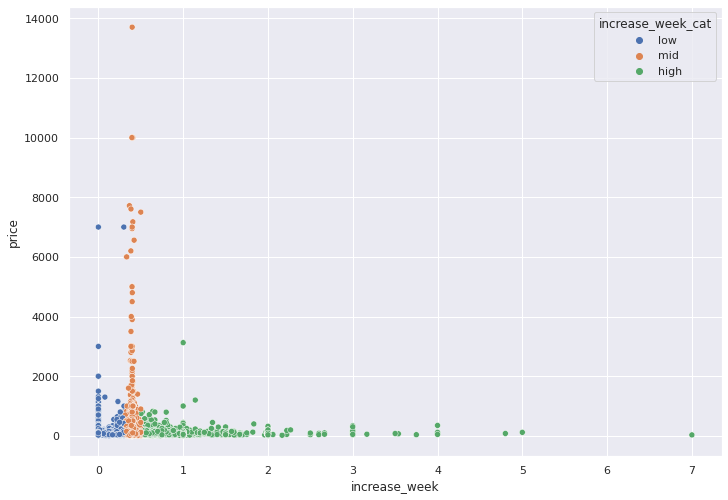

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(data=train1, x='increase_week', y='price', hue='increase_week_cat')

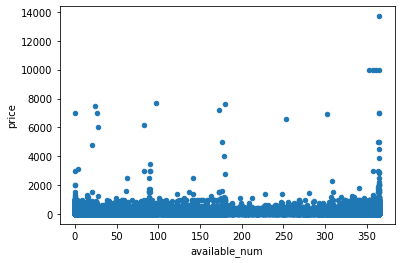

In [ ]:
calendar.groupby('listing_id')[['available_num']].sum().merge(train[['id', 'price']], 
                    how = 'right', left_on = 'listing_id', right_on = 'id').drop('id', axis = 1).plot.scatter(x = 'available_num', y = 'price')

In [ ]:
calendar.groupby('listing_id')[['available_num']].sum().merge(train[['id', 'price']], 
                    how = 'right', left_on = 'listing_id', right_on = 'id').drop('id', axis = 1)

,available_num,price
0,0.0,1000.0
1,365.0,771.0
2,365.0,1500.0
3,0.0,2000.0
4,363.0,901.0
...,...,...
51810,200.0,68.0
51811,175.0,349.0
51812,34.0,100.0
51813,180.0,69.0


## удобства

In [ ]:
result = pd.concat([train[['amenities']], test[['amenities']]])


In [ ]:
tmp = result.amenities\
.str.replace('{','')\
.str.replace('}','')\
.str.split(',', expand=True)\
.stack()\
.reset_index()[['level_0', 0]]

tmp['value'] = 1
tmp.rename({0:'amenities'}, axis=1, inplace=True)

tmp1 = tmp.pivot_table(values='value', index='level_0', columns='amenities', aggfunc=np.sum, fill_value=0)



In [ ]:
train = train.merge(tmp1, left_index=True, right_on = 'level_0', how='left').reset_index().drop('level_0', axis=1)
test = test.merge(tmp1, left_index=True, right_on = 'level_0', how='left').reset_index().drop('level_0', axis=1)

## sentiment analytics

In [ ]:
# reviews.dropna(how='any', inplace = True)

In [ ]:
# %%time

# from textblob import TextBlob
# import nltk
# nltk.download('punkt')

# reviews['sentiment'] = reviews['comments'].apply(lambda txt: TextBlob(txt).sentiment.polarity)
# reviews['subjectivity'] = reviews['comments'].apply(lambda txt: TextBlob(txt).sentiment.subjectivity)

# reviews.to_csv('/content/drive/My Drive/Colab Notebooks/HW03reviews.csv', index=True)

In [ ]:
# reviews.to_csv('/content/drive/My Drive/Colab Notebooks/HW03reviews.csv', index=True)

In [ ]:
sentiment_analytics = reviews.groupby('listing_id', as_index=False)\
.aggregate({'id':'count', 'sentiment':'median', 'subjectivity':'median'})\
.rename(columns = {'id':'reviews_count'})


In [ ]:
sentiment_analytics

,listing_id,reviews_count,sentiment,subjectivity
0,9554,132,0.389262,0.596548
1,11076,3,0.700000,0.600000
2,13913,14,0.360584,0.614265
3,17402,39,0.333333,0.554167
4,24328,92,0.405117,0.591930
...,...,...,...,...
56273,29735949,1,0.625000,0.766667
56274,29736900,1,0.230952,0.505556
56275,29756033,1,0.000000,0.000000
56276,29775194,1,0.000000,0.000000


In [ ]:
sentiment_analytics.reviews_count.quantile([.25, .5, .75])

0.25     3.0
0.50     8.0
0.75    22.0
Name: reviews_count, dtype: float64

In [ ]:
sentiment_analytics.loc[sentiment_analytics['reviews_count'] <= 3, 'reviews_count_cat'] = 'low'
sentiment_analytics.loc[sentiment_analytics['reviews_count'] > 22, 'reviews_count_cat'] = 'high'
sentiment_analytics['reviews_count_cat'].fillna('mid', inplace = True)

In [ ]:
sentiment_analytics['reviews_check'] = 't'

In [ ]:
sentiment_analytics

,listing_id,reviews_count,sentiment,subjectivity,reviews_count_cat,reviews_check
0,9554,132,0.389262,0.596548,high,t
1,11076,3,0.700000,0.600000,low,t
2,13913,14,0.360584,0.614265,mid,t
3,17402,39,0.333333,0.554167,high,t
4,24328,92,0.405117,0.591930,high,t
...,...,...,...,...,...,...
56273,29735949,1,0.625000,0.766667,low,t
56274,29736900,1,0.230952,0.505556,low,t
56275,29756033,1,0.000000,0.000000,low,t
56276,29775194,1,0.000000,0.000000,low,t


In [ ]:
train = train.merge(sentiment_analytics, how = 'left', left_on = 'id', right_on = 'listing_id').drop(['listing_id', 'reviews_count'],axis=1)
test = test.merge(sentiment_analytics, how = 'left', left_on = 'id', right_on = 'listing_id').drop(['listing_id', 'reviews_count'],axis=1)

In [ ]:
train.head(2)

,id,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,host_id,host_since,host_about,host_response_time,host_response_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,zipcode,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,cancellation_policy,...,Bidet,Breakfast,Cat(s),Crib,Dishwasher,Dog(s),Doorman,Dryer,Elevator,Essentials,Gym,Hammock,Hangers,Heating,Internet,Iron,Keypad,Kitchen,Kitchenette,Lockbox,Microwave,Mudroom,Netflix,Other,Oven,Pool,Printer,Refrigerator,Shampoo,Ski-in/Ski-out,Stove,TV,Terrace,Washer,Waterfront,Wifi,sentiment,subjectivity,reviews_count_cat,reviews_check
0,127860,Double bedroom in cottage Twickenham (sleeps 1-2),"One gorgeous, light-filled double bedroom (sle...","A beautiful, light-filled double bedroom is ou...","One gorgeous, light-filled double bedroom (sle...",none,"Very, very safe area, great transport links an...",We have a super-gorgeous cat,Twickenham Rugby Stadium is 15 mins walk Water...,"You'll have full use of the cottage, two recep...","The host (Andy) is usually in residence, but m...","While the house is a great space to entertain,...",161720,2010-07-09,My wife and I work in property development. S...,NaN,NaN,f,t,t,Richmond upon Thames,TW2 6,51.447147,-0.339253,t,House,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,Breakfast...",NaN,300.0,10.0,1,10.0,2,strict_14_with_grace_period,...,0,2,1,0,0,0,0,1,0,2,0,0,1,2,2,1,0,2,0,0,0,0,0,0,0,0,0,0,2,0,0,2,0,2,0,2,NaN,NaN,NaN,NaN
1,325809,Big House for Olympics sleeps 6 to8,NaN,"A beautiful, modern, art-filled and clean 4 st...","A beautiful, modern, art-filled and clean 4 st...",none,NaN,NaN,NaN,NaN,NaN,A copy of your passports or Id cards will be r...,1666422,2012-01-28,"Hi there,\r\n\r\nI'm a music artist manager an...",NaN,NaN,f,t,f,Camden,NW3 6NE,51.549993,-0.184546,t,House,Entire home/apt,8,2.5,3.0,4.0,Real Bed,"{""Cable TV"",Internet,Wifi,Kitchen,""Free parkin...",1400.0,771.0,NaN,1,0.0,14,strict_14_with_grace_period,...,0,1,0,0,0,1,0,1,0,0,0,0,0,2,2,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,2,NaN,NaN,NaN,NaN


In [ ]:
# поставить метку F у отелей без отзывов
train[['reviews_check']] = train[['reviews_check']].fillna('f')

test[['reviews_check']] = test[['reviews_check']].fillna('f')

In [ ]:
train = train.astype({
    'reviews_check': 'category', 
    'reviews_count_cat': 'category'
    })

test = test.astype({
    'reviews_check': 'category', 
    'reviews_count_cat': 'category'
    })

## Предобработка данных: приведение типов


In [ ]:
# преобразуем процент в число с плавающей точкой
train['host_response_rate'] = train['host_response_rate'].str.rstrip('%').astype('float') / 100.0
train.set_index('id', inplace=True)

test['host_response_rate'] = test['host_response_rate'].str.rstrip('%').astype('float') / 100.0
test.set_index('id', inplace=True)


# извлекаем год в host_since
train['year'] = pd.to_datetime(train['host_since']).dt.year
test['year'] = pd.to_datetime(test['host_since']).dt.year



In [ ]:
# приведение типов данных
train = train.astype({
    # 'id': str,
    'name': str,
    'summary' : str,
    'space': str,
    'description': str,
    'experiences_offered': 'category',
    'neighborhood_overview': str,
    'notes': str,
    'transit': str,
    'access': str,
    'interaction': str,
    'house_rules': str,
    'host_id': str,
    'host_since': 'datetime64[ns]',
    'host_about': str,
    'host_response_time': 'category',
    # 'host_response_rate': np.float16,
    'host_is_superhost': 'category',
    'host_has_profile_pic': 'category',
    'host_identity_verified': 'category',
    'neighbourhood_cleansed': 'category',
    'zipcode': 'category',
    #  'latitude': np.float16,
    #  'longitude': np.float16,
    'is_location_exact': 'category',
    'property_type': 'category',
    'room_type': 'category',
    'accommodates':int,
    #  'bathrooms': np.float16,
    # 'bedrooms': int,
    # 'beds':int,
    'bed_type': 'category',
    # 'amenities': object,
    #  'square_feet': np.float16,
    #  'security_deposit': np.float16,
    #  'cleaning_fee': np.float16,
    # 'guests_included': int,
    #  'extra_people': np.float16,
    # 'minimum_nights': int,
    'cancellation_policy': 'category',
    'require_guest_profile_picture': 'category',
    'require_guest_phone_verification': 'category',
    'year': 'category'
    })



test = test.astype({
    # 'id': str,
    'name': str,
    'summary' : str,
    'space': str,
    'description': str,
    'experiences_offered': 'category',
    'neighborhood_overview': str,
    'notes': str,
    'transit': str,
    'access': str,
    'interaction': str,
    'house_rules': str,
    'host_id': str,
    'host_since': 'datetime64[ns]',
    'host_about': str,
    'host_response_time': 'category',
    # 'host_response_rate': np.float16,
    'host_is_superhost': 'category',
    'host_has_profile_pic': 'category',
    'host_identity_verified': 'category',
    'neighbourhood_cleansed': 'category',
    'zipcode': 'category',
    #  'latitude': np.float16,
    #  'longitude': np.float16,
    'is_location_exact': 'category',
    'property_type': 'category',
    'room_type': 'category',
    'accommodates':int,
    #  'bathrooms': np.float16,
    # 'bedrooms': int,
    # 'beds':int,
    'bed_type': 'category',
    # 'amenities': object,
    #  'square_feet': np.float16,
    #  'security_deposit': np.float16,
    #  'cleaning_fee': np.float16,
    # 'guests_included': int,
    #  'extra_people': np.float16,
    # 'minimum_nights': int,
    'cancellation_policy': 'category',
    'require_guest_profile_picture': 'category',
    'require_guest_phone_verification': 'category',
    'year': 'category'
    })

In [ ]:
cat_train = train.select_dtypes('category')
num_train = train.select_dtypes([int, float])
description_train = train.select_dtypes(object)

# сat_test = test.select_dtypes('category')
# num_test = test.select_dtypes([int, float])
# description_test = test.select_dtypes(object)

num = list(num_train.drop('price',axis=1))
cat = list(cat_train)
txt = list(description_train)

## Исследование данных

In [ ]:
# пропущенные значения - Исключаем значения с большим кол-вом пропусков
train.isna().sum()

name                       0
summary                    0
space                      0
description                0
experiences_offered        0
                       ...  
sentiment              13603
subjectivity           13603
reviews_count_cat      13603
reviews_check              0
year                      11
Length: 241, dtype: int64

In [ ]:
test.isna().sum()

name                      0
summary                   0
space                     0
description               0
experiences_offered       0
                       ... 
sentiment              4934
subjectivity           4934
reviews_count_cat      4934
reviews_check             0
year                     14
Length: 240, dtype: int64

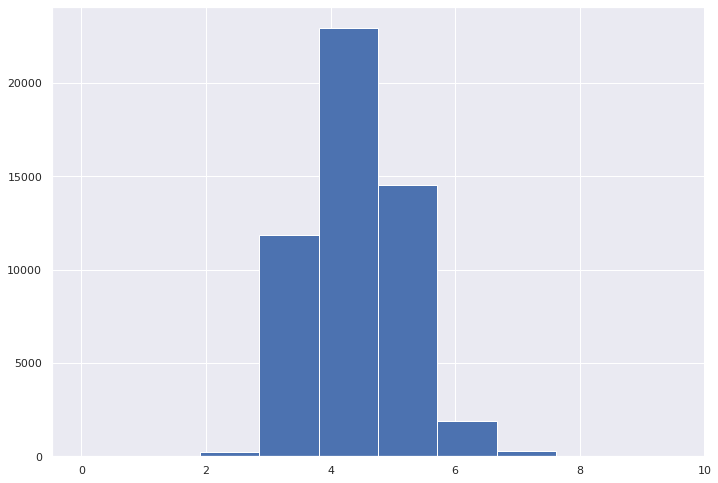

In [ ]:
# таргет имеет распределение отличное от норм, сильный перекоc в сторону дешевых отелей
# train.price.hist()

np.log(1 + train.price).hist()

In [ ]:
train.price[train.price==0]

id
14352218    0.0
18373061    0.0
18545675    0.0
18607614    0.0
19551457    0.0
20223145    0.0
20246482    0.0
20270756    0.0
20274559    0.0
20300732    0.0
20305863    0.0
20513280    0.0
20530877    0.0
20552433    0.0
20568208    0.0
20601806    0.0
20606819    0.0
20611942    0.0
20614766    0.0
20617686    0.0
20636274    0.0
20683887    0.0
20741019    0.0
21066424    0.0
21105318    0.0
21121131    0.0
21150478    0.0
21159079    0.0
21182077    0.0
21184137    0.0
21204967    0.0
21217951    0.0
21236327    0.0
21263279    0.0
21275117    0.0
21285424    0.0
21311769    0.0
21351616    0.0
21361509    0.0
21392064    0.0
Name: price, dtype: float64

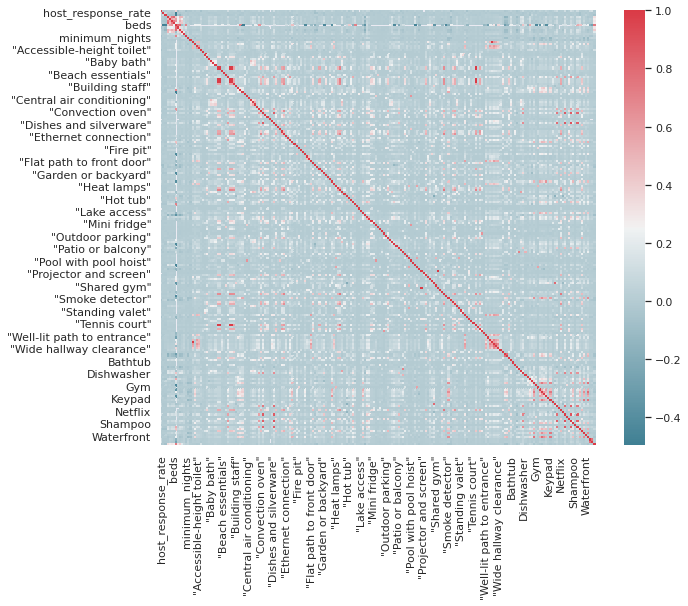

In [ ]:
# # скореллированные данные удалить - square_feet

f, ax = plt.subplots(figsize=(10, 8))
corr = train[num+['price']].corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [ ]:
categorical_variables = train.select_dtypes(include = ['category']).columns

In [ ]:
# исключить категориальную переменную с большим разбросом - zipcode
train[categorical_variables].nunique()

experiences_offered                     4
host_response_time                      4
host_is_superhost                       2
host_has_profile_pic                    2
host_identity_verified                  2
neighbourhood_cleansed                 33
zipcode                             23654
is_location_exact                       2
property_type                          40
room_type                               3
bed_type                                5
cancellation_policy                     6
require_guest_profile_picture           2
require_guest_phone_verification        2
reviews_count_cat                       3
reviews_check                           2
year                                   11
dtype: int64

In [ ]:
len(categorical_variables)

17

ValueError: ignored

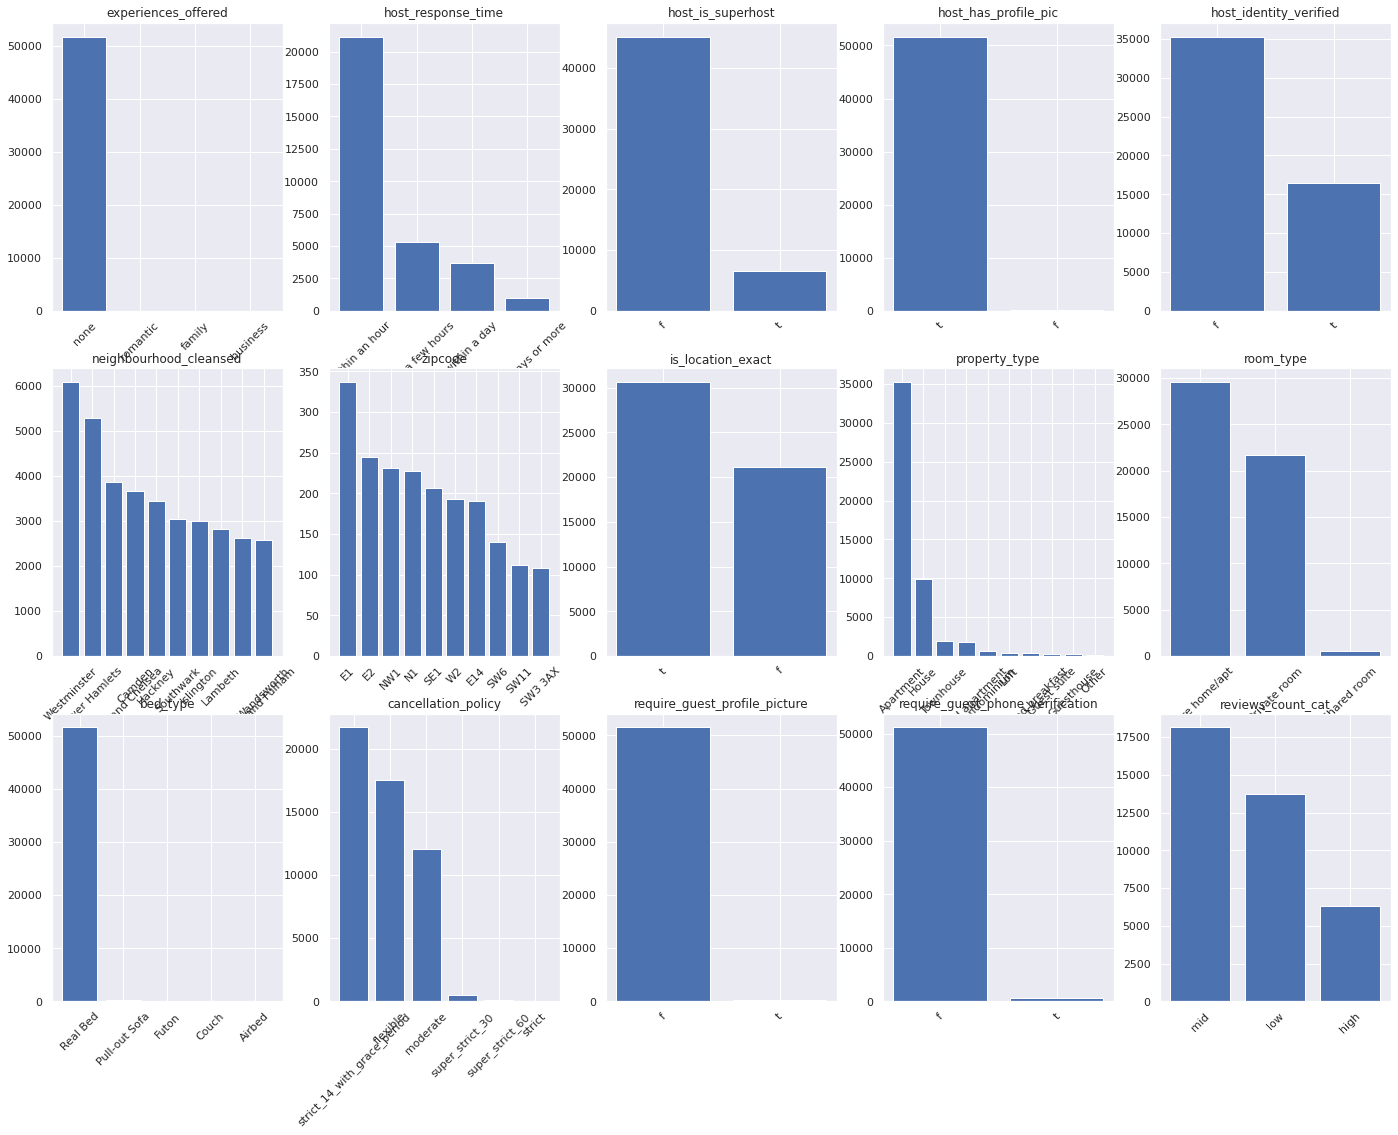

In [ ]:
# удалить изза дисбаланса классов ['experiences_offered', 'host_has_profile_pic', 'bed_type', 'require_guest_profile_picture', 'require_guest_phone_verification'],
plt.figure(figsize = (24, 18))

plot_number = 0
for feature_name in categorical_variables:
        plot_number += 1
        plt.subplot(3, 5, plot_number)
        plt.bar(x = train[feature_name].value_counts().nlargest(10).index, 
            height = train[feature_name].value_counts().nlargest(10).values)
        plt.title(feature_name)
        plt.xticks(rotation=45)




## Кластеризация гео!

In [ ]:
#Проверка на равномерность распределения классов
train['cl'] = 0
test['cl'] = 1

result = pd.concat([train.drop('price',axis=1), test])
# result = result.set_index('id')

X = result[['latitude', 'longitude']] #square_feet
y = result.cl

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
train.head(2)

,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,host_id,host_since,host_about,host_response_time,host_response_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,zipcode,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,cancellation_policy,require_guest_profile_picture,...,Cat(s),Crib,Dishwasher,Dog(s),Doorman,Dryer,Elevator,Essentials,Gym,Hammock,Hangers,Heating,Internet,Iron,Keypad,Kitchen,Kitchenette,Lockbox,Microwave,Mudroom,Netflix,Other,Oven,Pool,Printer,Refrigerator,Shampoo,Ski-in/Ski-out,Stove,TV,Terrace,Washer,Waterfront,Wifi,sentiment,subjectivity,reviews_count_cat,reviews_check,year,cl
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
127860,Double bedroom in cottage Twickenham (sleeps 1-2),"One gorgeous, light-filled double bedroom (sle...","A beautiful, light-filled double bedroom is ou...","One gorgeous, light-filled double bedroom (sle...",none,"Very, very safe area, great transport links an...",We have a super-gorgeous cat,Twickenham Rugby Stadium is 15 mins walk Water...,"You'll have full use of the cottage, two recep...","The host (Andy) is usually in residence, but m...","While the house is a great space to entertain,...",161720,2010-07-09,My wife and I work in property development. S...,NaN,NaN,f,t,t,Richmond upon Thames,TW2 6,51.447147,-0.339253,t,House,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,Breakfast...",NaN,300.0,10.0,1,10.0,2,strict_14_with_grace_period,f,...,1,0,0,0,0,1,0,2,0,0,1,2,2,1,0,2,0,0,0,0,0,0,0,0,0,0,2,0,0,2,0,2,0,2,NaN,NaN,NaN,f,2010.0,0
325809,Big House for Olympics sleeps 6 to8,nan,"A beautiful, modern, art-filled and clean 4 st...","A beautiful, modern, art-filled and clean 4 st...",none,nan,nan,nan,nan,nan,A copy of your passports or Id cards will be r...,1666422,2012-01-28,"Hi there,\r\n\r\nI'm a music artist manager an...",NaN,NaN,f,t,f,Camden,NW3 6NE,51.549993,-0.184546,t,House,Entire home/apt,8,2.5,3.0,4.0,Real Bed,"{""Cable TV"",Internet,Wifi,Kitchen,""Free parkin...",1400.0,771.0,NaN,1,0.0,14,strict_14_with_grace_period,f,...,0,0,0,1,0,1,0,0,0,0,0,2,2,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,2,NaN,NaN,NaN,f,2012.0,0


CPU times: user 10min 9s, sys: 7min 31s, total: 17min 41s
Wall time: 8min 57s


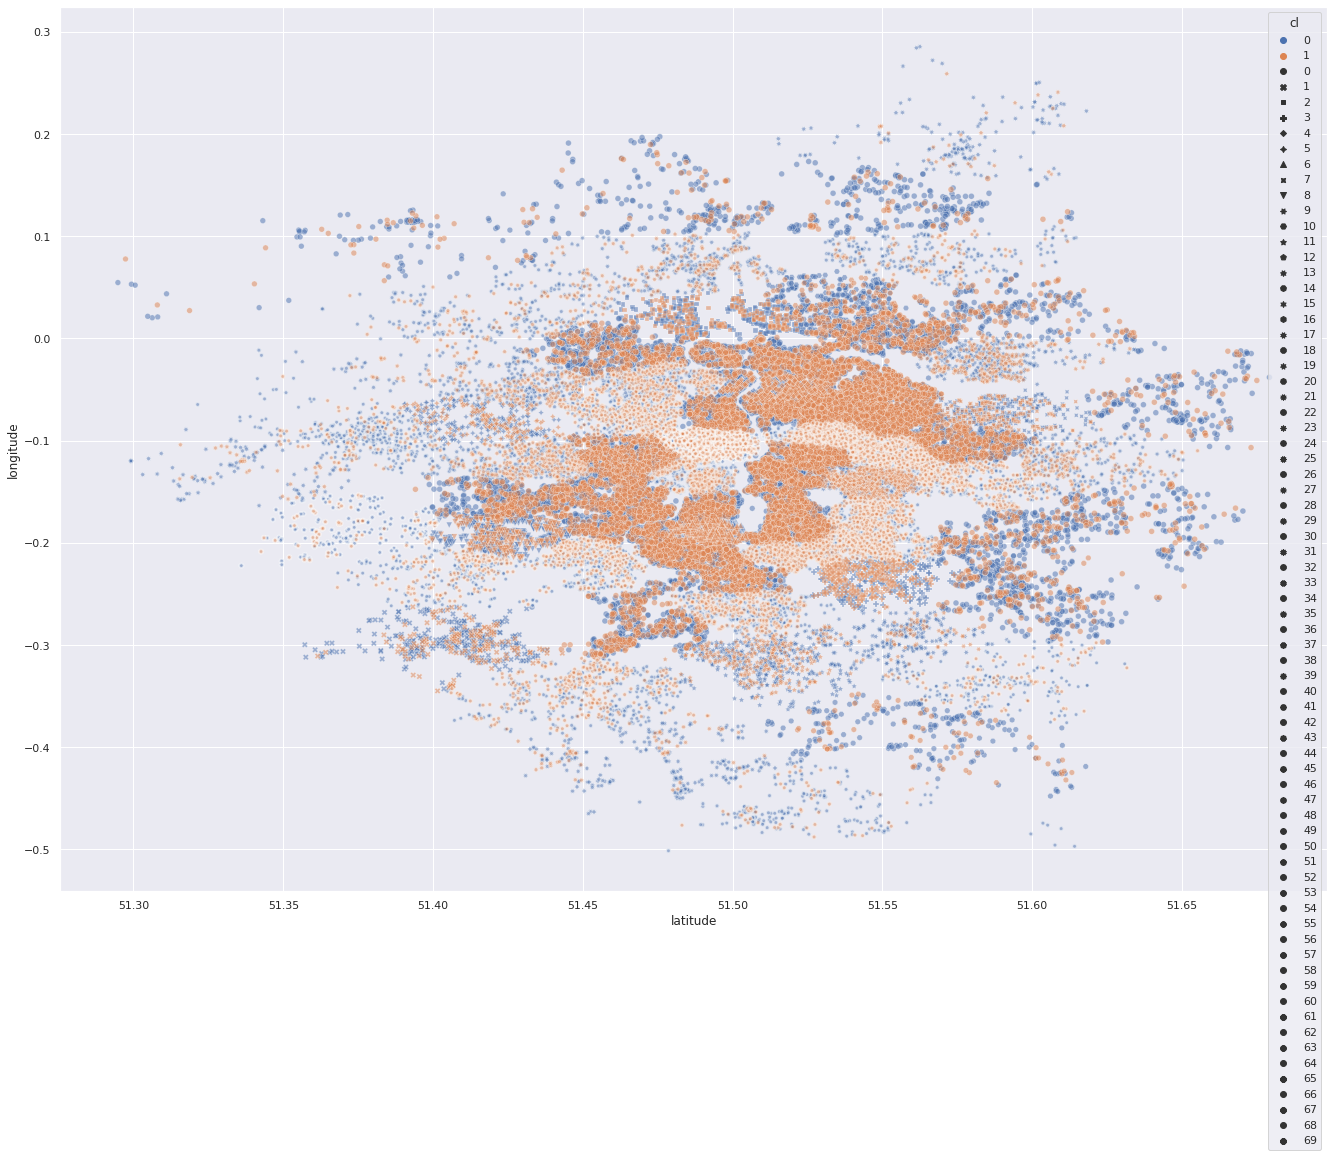

In [ ]:
%%time
matrix_by_knn = KMeans(init = 'k-means++', n_clusters = 140, n_init = 200).fit(X)
clusters_clients = matrix_by_knn.predict(X)

# from sklearn.cluster import DBSCAN
# epsDB = 1/100
# clustering = DBSCAN(eps=epsDB, min_samples=2).fit(X)
# clusters_clients = clustering.labels_


import seaborn as sns
sns.set(rc={'figure.figsize':(22.7,16.27)})
sns.scatterplot(x = X.latitude, y = X.longitude, hue = y, style = clusters_clients, alpha = 0.5)


In [ ]:
geo_analytics = pd.DataFrame({'Claster': clusters_clients})

In [ ]:
y.index

Int64Index([  127860,   325809,   429045,   473637,   533943,   882380,
             1279956,  1551262,  1583890,  1665188,
            ...
            13558915, 13558946, 13558977, 13559365, 13559427, 13559787,
            13561162, 13561394, 13561787, 13561861],
           dtype='int64', name='id', length=74815)

In [ ]:
geo_analytics['index'] = y.index


In [ ]:
geo_analytics = geo_analytics.astype({'Claster':'category'})

In [ ]:
geo_analytics = geo_analytics.set_index('index')

In [ ]:
train.head(2)

,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,host_id,host_since,host_about,host_response_time,host_response_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,zipcode,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,cancellation_policy,require_guest_profile_picture,...,Cat(s),Crib,Dishwasher,Dog(s),Doorman,Dryer,Elevator,Essentials,Gym,Hammock,Hangers,Heating,Internet,Iron,Keypad,Kitchen,Kitchenette,Lockbox,Microwave,Mudroom,Netflix,Other,Oven,Pool,Printer,Refrigerator,Shampoo,Ski-in/Ski-out,Stove,TV,Terrace,Washer,Waterfront,Wifi,sentiment,subjectivity,reviews_count_cat,reviews_check,year,cl
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
127860,Double bedroom in cottage Twickenham (sleeps 1-2),"One gorgeous, light-filled double bedroom (sle...","A beautiful, light-filled double bedroom is ou...","One gorgeous, light-filled double bedroom (sle...",none,"Very, very safe area, great transport links an...",We have a super-gorgeous cat,Twickenham Rugby Stadium is 15 mins walk Water...,"You'll have full use of the cottage, two recep...","The host (Andy) is usually in residence, but m...","While the house is a great space to entertain,...",161720,2010-07-09,My wife and I work in property development. S...,NaN,NaN,f,t,t,Richmond upon Thames,TW2 6,51.447147,-0.339253,t,House,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,Breakfast...",NaN,300.0,10.0,1,10.0,2,strict_14_with_grace_period,f,...,1,0,0,0,0,1,0,2,0,0,1,2,2,1,0,2,0,0,0,0,0,0,0,0,0,0,2,0,0,2,0,2,0,2,NaN,NaN,NaN,f,2010.0,0
325809,Big House for Olympics sleeps 6 to8,nan,"A beautiful, modern, art-filled and clean 4 st...","A beautiful, modern, art-filled and clean 4 st...",none,nan,nan,nan,nan,nan,A copy of your passports or Id cards will be r...,1666422,2012-01-28,"Hi there,\r\n\r\nI'm a music artist manager an...",NaN,NaN,f,t,f,Camden,NW3 6NE,51.549993,-0.184546,t,House,Entire home/apt,8,2.5,3.0,4.0,Real Bed,"{""Cable TV"",Internet,Wifi,Kitchen,""Free parkin...",1400.0,771.0,NaN,1,0.0,14,strict_14_with_grace_period,f,...,0,0,0,1,0,1,0,0,0,0,0,2,2,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,2,NaN,NaN,NaN,f,2012.0,0


In [ ]:
train = train.merge(geo_analytics, how = 'left', left_on = train.index, right_on = 'index').drop(['cl'],axis=1)
test = test.merge(geo_analytics, how = 'left', left_on = test.index, right_on = 'index').drop(['cl'],axis=1)

In [ ]:
train.head(2)

,index,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,host_id,host_since,host_about,host_response_time,host_response_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,zipcode,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,cancellation_policy,...,Cat(s),Crib,Dishwasher,Dog(s),Doorman,Dryer,Elevator,Essentials,Gym,Hammock,Hangers,Heating,Internet,Iron,Keypad,Kitchen,Kitchenette,Lockbox,Microwave,Mudroom,Netflix,Other,Oven,Pool,Printer,Refrigerator,Shampoo,Ski-in/Ski-out,Stove,TV,Terrace,Washer,Waterfront,Wifi,sentiment,subjectivity,reviews_count_cat,reviews_check,year,Claster
0,127860,Double bedroom in cottage Twickenham (sleeps 1-2),"One gorgeous, light-filled double bedroom (sle...","A beautiful, light-filled double bedroom is ou...","One gorgeous, light-filled double bedroom (sle...",none,"Very, very safe area, great transport links an...",We have a super-gorgeous cat,Twickenham Rugby Stadium is 15 mins walk Water...,"You'll have full use of the cottage, two recep...","The host (Andy) is usually in residence, but m...","While the house is a great space to entertain,...",161720,2010-07-09,My wife and I work in property development. S...,NaN,NaN,f,t,t,Richmond upon Thames,TW2 6,51.447147,-0.339253,t,House,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,Breakfast...",NaN,300.0,10.0,1,10.0,2,strict_14_with_grace_period,...,1,0,0,0,0,1,0,2,0,0,1,2,2,1,0,2,0,0,0,0,0,0,0,0,0,0,2,0,0,2,0,2,0,2,NaN,NaN,NaN,f,2010.0,41
1,325809,Big House for Olympics sleeps 6 to8,nan,"A beautiful, modern, art-filled and clean 4 st...","A beautiful, modern, art-filled and clean 4 st...",none,nan,nan,nan,nan,nan,A copy of your passports or Id cards will be r...,1666422,2012-01-28,"Hi there,\r\n\r\nI'm a music artist manager an...",NaN,NaN,f,t,f,Camden,NW3 6NE,51.549993,-0.184546,t,House,Entire home/apt,8,2.5,3.0,4.0,Real Bed,"{""Cable TV"",Internet,Wifi,Kitchen,""Free parkin...",1400.0,771.0,NaN,1,0.0,14,strict_14_with_grace_period,...,0,0,0,1,0,1,0,0,0,0,0,2,2,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,2,NaN,NaN,NaN,f,2012.0,45


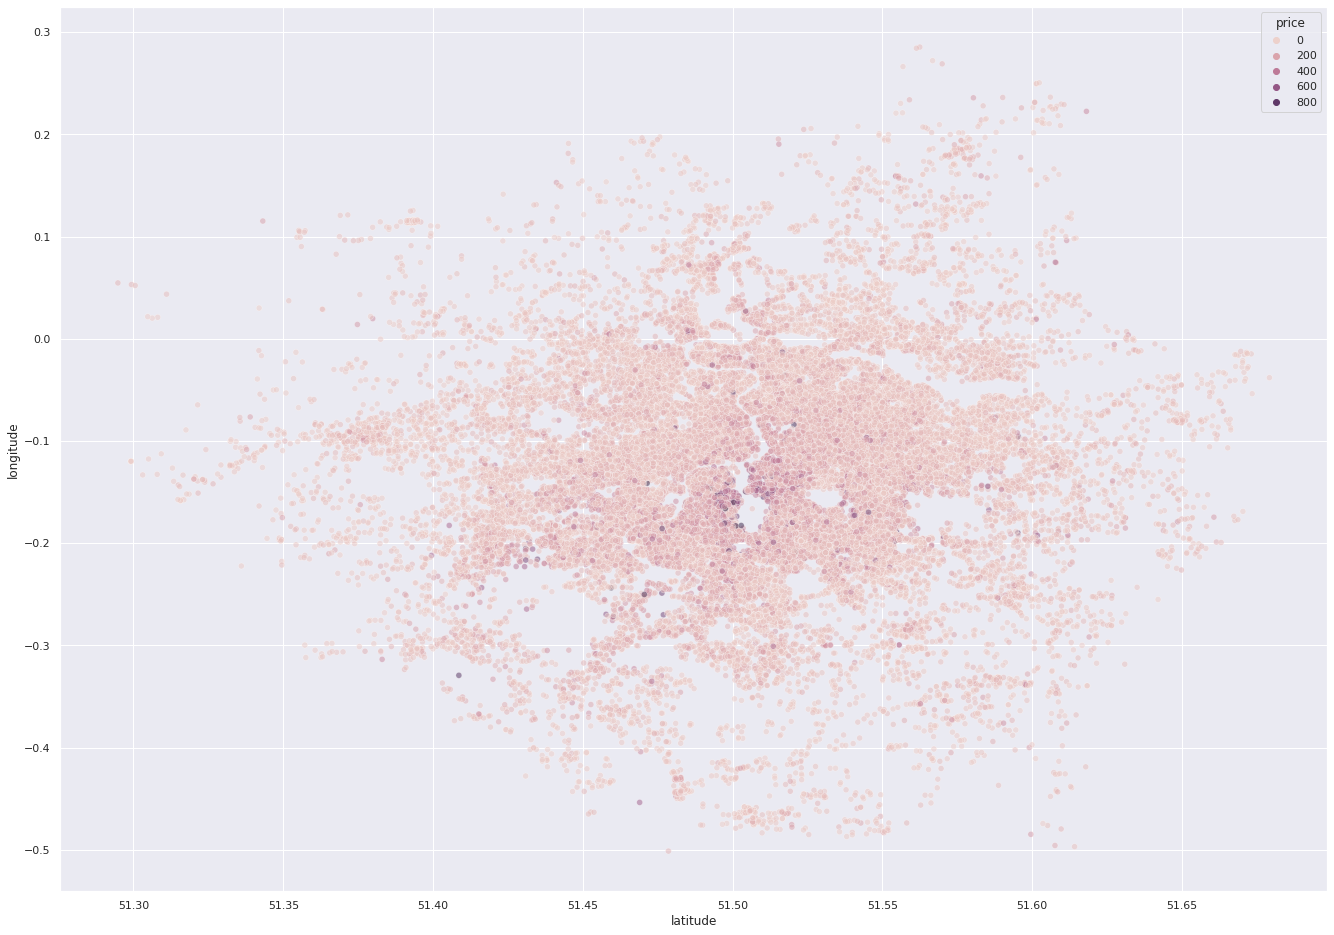

In [ ]:
import seaborn as sns
sns.set(rc={'figure.figsize':(22.7,16.27)})
sns.scatterplot(x = train.latitude[train.price < 1000], 
                y = train.longitude[train.price < 1000], 
                hue = train.price[train.price < 1000], 
                alpha = 0.5)

In [ ]:
result

,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,host_id,host_since,host_about,host_response_time,host_response_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,zipcode,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,cancellation_policy,require_guest_profile_picture,...,Cat(s),Crib,Dishwasher,Dog(s),Doorman,Dryer,Elevator,Essentials,Gym,Hammock,Hangers,Heating,Internet,Iron,Keypad,Kitchen,Kitchenette,Lockbox,Microwave,Mudroom,Netflix,Other,Oven,Pool,Printer,Refrigerator,Shampoo,Ski-in/Ski-out,Stove,TV,Terrace,Washer,Waterfront,Wifi,sentiment,subjectivity,reviews_count_cat,reviews_check,year,cl
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
127860,Double bedroom in cottage Twickenham (sleeps 1-2),"One gorgeous, light-filled double bedroom (sle...","A beautiful, light-filled double bedroom is ou...","One gorgeous, light-filled double bedroom (sle...",none,"Very, very safe area, great transport links an...",We have a super-gorgeous cat,Twickenham Rugby Stadium is 15 mins walk Water...,"You'll have full use of the cottage, two recep...","The host (Andy) is usually in residence, but m...","While the house is a great space to entertain,...",161720,2010-07-09,My wife and I work in property development. S...,NaN,NaN,f,t,t,Richmond upon Thames,TW2 6,51.447147,-0.339253,t,House,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,Breakfast...",NaN,300.0,10.0,1,10.0,2,strict_14_with_grace_period,f,...,1,0,0,0,0,1,0,2,0,0,1,2,2,1,0,2,0,0,0,0,0,0,0,0,0,0,2,0,0,2,0,2,0,2,NaN,NaN,NaN,f,2010.0,0
325809,Big House for Olympics sleeps 6 to8,nan,"A beautiful, modern, art-filled and clean 4 st...","A beautiful, modern, art-filled and clean 4 st...",none,nan,nan,nan,nan,nan,A copy of your passports or Id cards will be r...,1666422,2012-01-28,"Hi there,\r\n\r\nI'm a music artist manager an...",NaN,NaN,f,t,f,Camden,NW3 6NE,51.549993,-0.184546,t,House,Entire home/apt,8,2.5,3.0,4.0,Real Bed,"{""Cable TV"",Internet,Wifi,Kitchen,""Free parkin...",1400.0,771.0,NaN,1,0.0,14,strict_14_with_grace_period,f,...,0,0,0,1,0,1,0,0,0,0,0,2,2,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,2,NaN,NaN,NaN,f,2012.0,0
429045,The Old Coach House (Olympics),nan,"Fabulous, recently refurbished original Victor...","Fabulous, recently refurbished original Victor...",none,nan,nan,nan,nan,nan,nan,2132532,2012-04-13,"I am making available a fabulous, recently ref...",NaN,NaN,f,t,f,Lewisham,SE10,51.469213,-0.007671,t,House,Entire home/apt,6,3.0,3.0,3.0,Real Bed,"{TV,Internet,Wifi,Kitchen,""Free parking on pre...",1800.0,600.0,NaN,1,0.0,14,strict_14_with_grace_period,f,...,0,1,0,0,0,1,0,1,0,0,1,2,1,1,0,2,0,0,0,0,0,0,1,0,0,1,1,0,1,2,0,2,0,2,NaN,NaN,NaN,f,2012.0,0
473637,Brand New contemporary mews house,nan,Stunning contemporary mews available for let o...,Stunning contemporary mews available for let o...,none,nan,nan,nan,nan,nan,"No smoking indoors,",359943,2011-01-24,"Run a design agency, and are passionate about ...",within an hour,1.0,f,t,t,Kensington and Chelsea,W11 2EH,51.515491,-0.206302,t,House,Entire home/apt,9,4.0,4.0,6.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Indoor f...",2100.0,300.0,100.0,7,100.0,14,strict_14_with_grace_period,f,...,0,0,1,0,0,2,1,1,0,0,1,2,1,1,0,2,0,0,1,0,0,1,1,0,0,1,1,0,1,2,0,2,0,2,NaN,NaN,NaN,f,2011.0,0
533943,LUXURY APT. NEAR BUCKINGHAM PALACE,“The area around Westminster Cathedral has lon...,"This stunning, spacious, 4 bedroom, top floor ...",“The area around Westminster Cathedral has lon...,family,The proximity of all of London's main attracti...,nan,"Only 5 minutes walk to Victoria Station, the m...",nan,I will not interfere at all during the stay of...,nan,1830359,2012-02-29,"I'm Catalan, originally from Barcelona and ha

In [ ]:
# train.to_csv('/content/drive/My Drive/Colab Notebooks/hw03-train.csv', index=False)
# test.to_csv('/content/drive/My Drive/Colab Notebooks/hw03-test.csv', index=False)

## Предобработка данных. Дроп лист



In [ ]:
# логарифмируем метрику
train = train[train.price > 0]
train.price = np.log(1 + train.price)

In [ ]:
train.host_since = pd.to_datetime(train.host_since, format='%Y-%m-%d')
train['host_exists'] = train.host_since - pd.to_datetime("2020-12-01", format='%Y-%m-%d')
train['host_exists'] = train['host_exists'].apply(lambda x: x.days)

In [ ]:
test.host_since = pd.to_datetime(test.host_since, format='%Y-%m-%d')
test['host_exists'] = test.host_since - pd.to_datetime("2020-12-01", format='%Y-%m-%d')
test['host_exists'] = test['host_exists'].apply(lambda x: x.days)

In [ ]:
test.head()

,index,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,host_id,host_since,host_about,host_response_time,host_response_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,zipcode,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,cancellation_policy,...,Crib,Dishwasher,Dog(s),Doorman,Dryer,Elevator,Essentials,Gym,Hammock,Hangers,Heating,Internet,Iron,Keypad,Kitchen,Kitchenette,Lockbox,Microwave,Mudroom,Netflix,Other,Oven,Pool,Printer,Refrigerator,Shampoo,Ski-in/Ski-out,Stove,TV,Terrace,Washer,Waterfront,Wifi,sentiment,subjectivity,reviews_count_cat,reviews_check,year,Claster,host_exists
0,9554,"Cozy, 3 minutes to Piccadilly Line",PLEASE CONTACT ME BEFORE BOOKING Homely apartm...,"Hello people, This is a bright, comfortable ro...",PLEASE CONTACT ME BEFORE BOOKING Homely apartm...,none,Details to follow..,NaN,details to follow when i get a chance..,"Kitchen, small dining / smoking room (if you s...",Depends on what else I have on.. It is always ...,"If you smoke, please do so only in the little ...",31655,2009-08-14,Please contact me before booking! Please see d...,within an hour,1.00,t,t,f,Haringey,N8 0EY,51.587767,-0.105666,f,Apartment,Private room,2,NaN,1.0,1.0,Real Bed,"{TV,Internet,Wifi,Kitchen,""Smoking allowed"",Br...",NaN,NaN,7.0,1,15.0,1,strict_14_with_grace_period,...,0,0,0,0,1,0,2,0,0,1,2,2,1,0,2,0,0,0,0,0,0,0,0,0,0,2,0,0,2,0,2,0,2,0.389262,0.596548,high,t,2009.0,36,-4127.0
1,11076,The Sanctuary,The room has a double bed and a single foldawa...,This Listing is for The Sanctury The accommoda...,The room has a double bed and a single foldawa...,none,"Ealing Broadway, as short walk from our place ...",NaN,extemely good transport links to central londo...,Huge family kitchen and good wifi,We give everyone a great welcome and make sure...,We don't allow alcohol or takeaways,40471,2009-09-22,"Hi, I'm Rosa, I'm one of the owners of the At-...",within a day,0.75,f,t,f,Ealing,W13 8,51.515645,-0.314508,t,Apartment,Private room,2,NaN,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Breakfast,""Pets l...",NaN,NaN,NaN,2,35.0,2,strict_14_with_grace_period,...,0,0,1,0,1,0,0,0,0,0,2,2,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,2,0.700000,0.600000,low,t,2009.0,11,-4088.0
2,13913,Holiday London DB Room Let-on going,My bright double bedroom with a large window h...,"Hello Everyone, I'm offering my lovely double ...",My bright double bedroom with a large window h...,business,Finsbury Park is a friendly melting pot commun...,For art lovers I can give guest my Tate Member...,The flat only a 10 minute walk to Finsbury Par...,Guest will have access to the self catering ki...,I like to have little chats with my guest over...,I'm an artist and have my artwork up on the wa...,54730,2009-11-16,I am a Multi-Media Visual Artist and Creative ...,within an hour,1.00,f,t,f,Islington,N4 3,51.568017,-0.111208,t,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Wifi,Kitchen,""Paid parking off ...",538.0,100.0,15.0,1,15.0,1,moderate,...,1,0,0,0,1,0,1,0,0,1,2,1,1,0,2,0,0,0,0,0,0,1,0,0,1,1,0,1,2,0,2,0,2,0.360584,0.614265,mid,t,2009.0,36,-4033.0
3,17402,Superb 3-Bed/2 Bath & Wifi: Trendy W1,"Open from June 2018 after a 3-year break, we a...",Ready again from June 2018 for bookings after ...,"Open from June 2018 after a 3-year break, we a...",none,"Location, location, location! You won't find b...",This property has new flooring throughout. Gue...,You can walk to tourist London or take numerou...,Full use of whole independent apartment,"Always available by email or phone (before, du...",The apartment benefits from new flooring throu...,67564,2010-01-04,We are Liz and Jack. We manage a number of ho...,NaN,NaN,t,t,t,Westminster,W1T4BP,51.520982,-0.140024,t,Apartment,Entire home/apt,6,2.0,3.0,3.0

In [ ]:
drop_list = [
# 'space', 
# 'neighborhood_overview', 
# 'notes', 
# 'transit', 
# 'access', 
# 'interaction', 
# 'house_rules', 
# 'host_about', 
# 'host_id',
# 'host_response_time', 
# 'host_response_rate', 
# 'square_feet', 
# 'security_deposit', 
# 'zipcode',
# 'cleaning_fee', 
# 'experiences_offered', 
# 'host_has_profile_pic', 
# 'bed_type', 
# 'require_guest_profile_picture', 
# 'require_guest_phone_verification', 
'latitude', 
'longitude', 
'year', 
'increase_week', 
'amenities'
]

In [ ]:
train = train.drop(drop_list, axis=1)
test = test.drop(drop_list, axis=1)

In [ ]:
test.head(2)

,index,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,host_id,host_since,host_about,host_response_time,host_response_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,zipcode,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,square_feet,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,increase_week_cat,...,Cat(s),Crib,Dishwasher,Dog(s),Doorman,Dryer,Elevator,Essentials,Gym,Hammock,Hangers,Heating,Internet,Iron,Keypad,Kitchen,Kitchenette,Lockbox,Microwave,Mudroom,Netflix,Other,Oven,Pool,Printer,Refrigerator,Shampoo,Ski-in/Ski-out,Stove,TV,Terrace,Washer,Waterfront,Wifi,sentiment,subjectivity,reviews_count_cat,reviews_check,Claster,host_exists
0,9554,"Cozy, 3 minutes to Piccadilly Line",PLEASE CONTACT ME BEFORE BOOKING Homely apartm...,"Hello people, This is a bright, comfortable ro...",PLEASE CONTACT ME BEFORE BOOKING Homely apartm...,none,Details to follow..,NaN,details to follow when i get a chance..,"Kitchen, small dining / smoking room (if you s...",Depends on what else I have on.. It is always ...,"If you smoke, please do so only in the little ...",31655,2009-08-14,Please contact me before booking! Please see d...,within an hour,1.00,t,t,f,Haringey,N8 0EY,f,Apartment,Private room,2,NaN,1.0,1.0,Real Bed,NaN,NaN,7.0,1,15.0,1,strict_14_with_grace_period,t,f,mid,...,1,0,0,0,0,1,0,2,0,0,1,2,2,1,0,2,0,0,0,0,0,0,0,0,0,0,2,0,0,2,0,2,0,2,0.389262,0.596548,high,t,36,-4127.0
1,11076,The Sanctuary,The room has a double bed and a single foldawa...,This Listing is for The Sanctury The accommoda...,The room has a double bed and a single foldawa...,none,"Ealing Broadway, as short walk from our place ...",NaN,extemely good transport links to central londo...,Huge family kitchen and good wifi,We give everyone a great welcome and make sure...,We don't allow alcohol or takeaways,40471,2009-09-22,"Hi, I'm Rosa, I'm one of the owners of the At-...",within a day,0.75,f,t,f,Ealing,W13 8,t,Apartment,Private room,2,NaN,1.0,1.0,Real Bed,NaN,NaN,NaN,2,35.0,2,strict_14_with_grace_period,f,f,low,...,0,0,0,1,0,1,0,0,0,0,0,2,2,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,2,0.700000,0.600000,low,t,11,-4088.0


## Подготовка модели

In [ ]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

In [ ]:
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))


pipeline_num = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaling', StandardScaler()), 
    ('normal', PowerTransformer())
])

pipeline_cat = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoding', OneHotEncoder(handle_unknown='ignore')),
])

pipeline_txt = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=' I ')),
    ('vectorizer', CountVectorizer(tokenizer=LemmaTokenizer(), lowercase=True, stop_words=set(stop_words))),
    # ('pca', TruncatedSVD(n_components=2))
    # ('vectorizer',  TfidfVectorizer(analyzer = 'word', ngram_range = (1,3), stop_words=set(stop_words))),

])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
cat_train = train.select_dtypes('category')
num_train = train.select_dtypes([int, float])
description_train = train.select_dtypes(object)

num = list(num_train.drop('price',axis=1))
cat = list(cat_train)
txt = list(description_train)


preprocessor = ColumnTransformer(
    transformers=[
        ('num', pipeline_num, num),
        ('cat', pipeline_cat, cat),
        ('txt', pipeline_cat, txt),
        ], remainder="passthrough")


In [ ]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 

    y_true = 2.718281828459045 ** y_true - 1
    y_pred = 2.718281828459045 ** y_pred - 1


    y_true = y_true.values.ravel()
    y_pred = y_pred.reshape(1, -1)[0]

    
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

In [ ]:
pipeline_lr = Pipeline(steps=[('preprocessor', preprocessor),        
                ('model', LinearRegression())
                ])

In [ ]:
pipeline_gbr = Pipeline(steps=[('preprocessor', preprocessor),        
                ('gbr', GradientBoostingRegressor(loss='lad', n_estimators=1500))
                ])

In [ ]:
pipeline_lasso = Pipeline(steps=[('preprocessor', preprocessor),        
                ('model', linear_model.Lasso(alpha=0.1))
                ])

In [ ]:
pipeline_ridge = Pipeline(steps=[('preprocessor', preprocessor),        
                ('model', Ridge(alpha=0.1))
                ])

In [ ]:
import xgboost as xgb

# param_dist = {'objective':'binary:logistic', 'n_estimators':2}

pipeline_xgb = Pipeline(steps=[('preprocessor', preprocessor),        
                ('xgb', xgb.XGBRegressor(nthread=-1, feval = mean_absolute_percentage_error))  #objective = 'reg:squarederror' 
                ])

In [ ]:
!pip install catboost

In [ ]:
from catboost import Pool, CatBoostRegressor


pipeline_cat = Pipeline(steps=[('preprocessor', preprocessor),        
                ('cat', CatBoostRegressor(loss_function='MAPE', logging_level = 'Silent'))  
                ])

In [ ]:
import lightgbm as lgb

pipeline_lgb = Pipeline(steps=[('preprocessor', preprocessor),        
                ('lgb', lgb.LGBMRegressor())  
                ])

In [ ]:
from sklearn.linear_model import SGDRegressor

pipeline_sgd = Pipeline(steps=[('preprocessor', preprocessor),        
                ('sgd', SGDRegressor())  
                ])

In [ ]:
from sklearn.decomposition import TruncatedSVD
pipeline_pca = Pipeline(steps=[('preprocessor', preprocessor),        
                ('pca', TruncatedSVD(n_components=2))
                ])

In [ ]:
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import RadiusNeighborsRegressor
pipeline_knn = Pipeline(steps=[('preprocessor', preprocessor),    
                ('knn', RadiusNeighborsRegressor(radius=1.0))
                ])

In [ ]:

from sklearn.cluster import DBSCAN
pipeline_dbscan = Pipeline(steps=[('preprocessor', preprocessor), 
                ('pca', TruncatedSVD(n_components=2)),    
                ('dbscan', DBSCAN(eps=0.0005, min_samples=2))
                ])

## обучаем модель

In [ ]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 

    y_true = 2.718281828459045 ** y_true - 1
    y_pred = 2.718281828459045 ** y_pred - 1


    y_true = y_true.values.ravel()
    y_pred = y_pred.reshape(1, -1)[0]

    
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

In [ ]:
q1 = train.price.quantile(0.01)

In [ ]:
q2 = train.price.quantile(0.99)

In [ ]:
# X = train.drop('price',axis=1)
# y = train.price.values

X = train.query('price < @q2 & price > @q1').drop(['price'], axis=1)[num+cat+txt]
y = train.query('price < @q2 & price > @q1').price

# X = train[num+cat+txt]
# y = train.price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.32, random_state=42)


In [ ]:
models = [
    # pipeline_lr,
    # pipeline_gbr,
    # pipeline_xgb,
    pipeline_cat,
    # pipeline_lasso,
    # pipeline_ridge,
    # pipeline_sgd,
    # pipeline_lgb,
]

mape = make_scorer(mean_absolute_percentage_error)

for model in models:
    %time print(cross_val_score(model, X_train, y_train, cv=3, scoring = mape))
    print()

# for i in [0.9, 0.8, 0.7, 0.5, 0.3]:
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= i , random_state=42)
#     %time print(cross_val_score(pipeline_cat, X_train, y_train, cv=3, scoring = mape), X_train.shape)
#     print()


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


[28.2152658  28.92945887 27.71218003]
CPU times: user 6min 57s, sys: 4.7 s, total: 7min 2s
Wall time: 4min 38s



In [ ]:
# from sklearn.ensemble import StackingRegressor
# estimators = [('lgb', pipeline_lgb), ('cat', pipeline_cat), ('lr', pipeline_lr)]

# reg = StackingRegressor(estimators = estimators, final_estimator = xgb.XGBRegressor(nthread=-1, feval = mean_absolute_percentage_error))

# reg.fit(X_train, y_train)

In [ ]:
y_pred = reg.predict(X_test)
print(mean_absolute_percentage_error(y_test, y_pred))

28.680167419827125


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(0.5, 1.0, 'Residual plot')

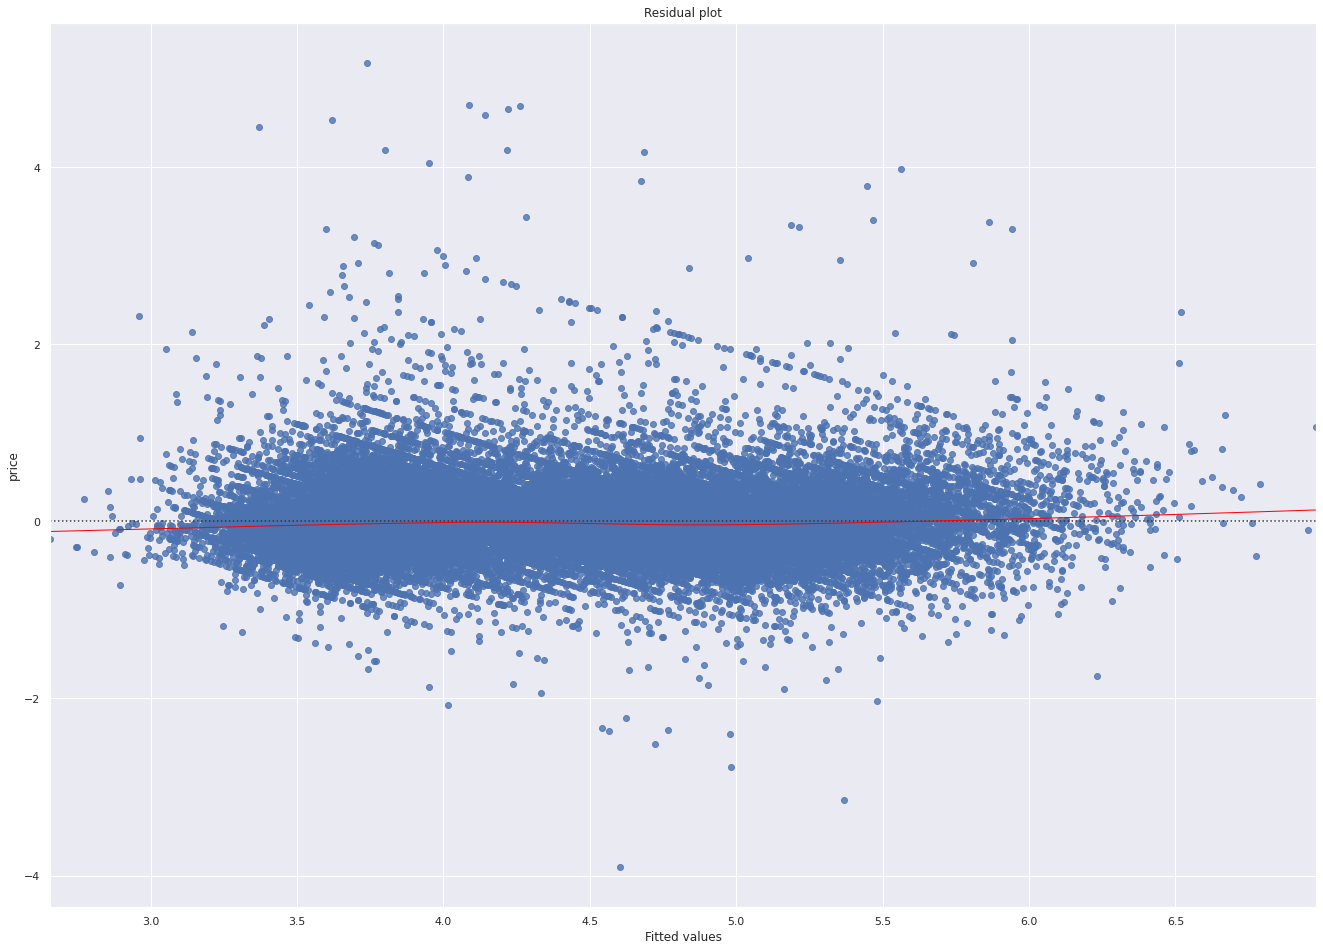

In [ ]:
p1 = sns.residplot(y_pred.reshape(-1), y_test, lowess=True,label=y_test.index, line_kws={'color': 'red', 'lw': 1, 'alpha': 1})

# for line in range(0, (y_test.shape[0] - 1)):
#   p1.text(y_pred.reshape(-1)[line], y_test[line], y_test.index[line])

plt.xlabel("Fitted values")
plt.title('Residual plot')

In [ ]:
# получить список гиперпараметров
# pipeline_knn.get_params().keys()

In [ ]:
%%time
# param = {'xgb__objective':['reg:linear'], 
#          'xgb__learning_rate': [.07], 
#          'xgb__max_depth': [5, 7],
#          'xgb__min_child_weight': [4],
#          'xgb__silent': [1],
#          'xgb__subsample': [0.7],
#          'xgb__colsample_bytree': [0.7],
#          'xgb__n_estimators': [500, 1000]
#          }


# mape = make_scorer(mean_absolute_percentage_error)

# grid = GridSearchCV(pipeline_xgb, param_grid=param, cv=3, scoring = mape)

# grid.fit(X_train, y_train)


In [ ]:
# # сохраняем лучшие параметры
# best = grid.best_estimator_
# best

In [ ]:
# grid.best_score_

In [ ]:
%%time
mape = make_scorer(mean_absolute_percentage_error)

pipeline_cat.fit(X, y)
y_pred = pipeline_cat.predict(X_test[X.columns])
print(mean_absolute_percentage_error(y_test, y_pred))

23.87554253496004
CPU times: user 53min, sys: 30.9 s, total: 53min 31s
Wall time: 42min 48s


In [ ]:
y_test[y_test>0]

41194    5.525453
5493     4.110874
2856     3.258097
4902     3.931826
5884     4.709530
           ...   
27203    4.709530
7067     4.615121
23348    3.713572
14081    4.043051
48753    3.713572
Name: price, Length: 16260, dtype: float64

In [ ]:
p1 = sns.residplot(y_pred.reshape(-1), y_test, lowess=True,label=y_test.index, line_kws={'color': 'red', 'lw': 1, 'alpha': 1})

# for line in range(0, (y_test.shape[0] - 1)):
#   p1.text(y_pred.reshape(-1)[line], y_test[line], y_test.index[line])

plt.xlabel("Fitted values")
plt.title('Residual plot')

In [ ]:
from scipy import stats

residuals = y_test - y_pred.reshape(-1)
residuals

plt.figure(figsize=(7,7))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot")

In [ ]:
model_norm_residuals_abs_sqrt=np.sqrt(np.abs(y_pred))

plt.figure(figsize=(7,7))
sns.regplot(y_pred.reshape(-1), model_norm_residuals_abs_sqrt,
              scatter=True,
              lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.ylabel("Standarized residuals")
plt.xlabel("Fitted value")

In [ ]:
list(set(X.columns.values) - set(test.columns.values))

[]

In [ ]:
list(set(test.columns.values) - set(X.columns.values))

['Unnamed: 44', 'host_since']

In [ ]:
test.columns.values

array(['index', 'name', 'summary', 'space', 'description',
       'experiences_offered', 'neighborhood_overview', 'notes', 'transit',
       'access', 'interaction', 'house_rules', 'host_id', 'host_since',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_is_superhost', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_cleansed', 'zipcode',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'square_feet',
       'security_deposit', 'cleaning_fee', 'guests_included',
       'extra_people', 'minimum_nights', 'cancellation_policy',
       'require_guest_profile_picture',
       'require_guest_phone_verification', 'increase_week_cat',
       'Unnamed: 44', ' toilet"', '"24-hour check-in"',
       '"Accessible-height bed"', '"Accessible-height toilet"',
       '"Air conditioning"', '"Air purifier"', '"Alfresco bathtub"',
       '"Amazon Echo"', '"BBQ grill"', '"Baby b

In [ ]:
X.columns.values

237

## kaggle

In [ ]:
y_pred = pipeline_cat.predict(test[X.columns])
y_pred = 2.718281828459045 ** y_pred - 1
test['price'] = y_pred #.reshape(1, -1)[0].tolist()
test.price[test.price < 0] = 0
test[['index', 'price']].to_csv('/content/drive/My Drive/Colab Notebooks/HW03-cat-24-all.csv', index=False)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
test[['index', 'price']].to_csv('/content/drive/My Drive/Colab Notebooks/HW03-cat-24-all.csv', index=False)

In [ ]:
# Play an audio beep. Any audio URL will do.
from google.colab import output
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')